<a href="https://colab.research.google.com/github/NguyenThuan215/ML-echo-cardiography/blob/main/echocardiography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thư viện

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive
import os

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from collections import namedtuple
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import DataLoader

# Kết nối với data

In [ ]:
# drive.mount("/content/drive")
# !unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"
# traindir = "DATA_CHAMBER_2021/train"
# testdir = "DATA_CHAMBER_2021/test"

In [ ]:
!git clone https://github.com/NguyenThuan215/ML-echo-cardiography
traindir = "/content/ML-echo-cardiography/DATA_CHAMBER_2021/train"
testdir = "/content/ML-echo-cardiography/DATA_CHAMBER_2021/test"

Cloning into 'ML-echo-cardiography'...
remote: Enumerating objects: 8348, done.
remote: Counting objects: 100% (8348/8348), done.
remote: Compressing objects: 100% (8345/8345), done.
remote: Total 8348 (delta 10), reused 8327 (delta 1), pack-reused 0
Receiving objects: 100% (8348/8348), 488.03 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (8328/8328), done.


# Chuẩn bị dữ liệu:
1. Các lớp: {2C, 3C, 4C}
2. Đọc dữ liệu trong file 'traindir' và 'testdir'
3. Đưa dữ liệu vào các batch để xử lý song song


In [ ]:
TrainTest = namedtuple('TrainTest', ['train', 'test'])

def get_classes():
  classes = ['2C', '3C', '4C']
  return classes

def prepare_data():
  image_size = 224
  transform_train = transforms.Compose([
      transforms.Resize((image_size,image_size)),                                    
      transforms.ToTensor(),
  ])
  transform_test = transforms.Compose([
      transforms.Resize((image_size,image_size)),
      transforms.ToTensor(),
  ])
  trainset = torchvision.datasets.ImageFolder(root=traindir, transform=transform_train)
  testset = torchvision.datasets.ImageFolder(root=testdir, transform=transform_test)
  return TrainTest(train=trainset, test=testset)

def prepare_loader(datasets):
  batch = 32
  worker = 4
  trainloader = DataLoader(dataset=datasets.train, batch_size=batch, shuffle=True, num_workers=worker)
  testloader = DataLoader(dataset=datasets.test, batch_size=batch, shuffle=False, num_workers=worker)
  return TrainTest(train=trainloader, test=testloader)

# Train/Test mô hình:
1. Train: với mỗi batch trong tập train:
  - Cho ảnh đi qua model
  - Tính lỗi bằng hàm lỗi "loss_func"
  - Cập nhật tham số
  - Báo cáo sau "reporting_steps" bước
2. Test:
  - Đặt model ở chế độ đánh giá (evaluate)
  - Tính toán đầu ra cho từng ảnh
  - trả về nhãn dự đoán/nhãn thực

In [ ]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  model.train()
  running_loss = 0.0
  reporting_steps = 40
  step = 0
  for images, labels in loader:
    step += 1
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if step % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} step {step} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0

def test_epoch(epoch, model, loader, device):
  ytrue = []
  ypred = []
  with torch.no_grad():
    model.eval()
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())

  return ypred, ytrue

# Tạo và thực nghiệm mô hình:
1. Tham số truyền vào main:
  - "PATH": file lưu lại mô hình
  - "model_in": string thể hiện tên mô hình muốn thực nghiệm.
2. Sửa đổi đầu ra của lớp Linear cuối cùng thành "3" để phù hợp với yêu cầu bào toán
3. Sử dụng hàm lỗi CrossEntropyLoss, hàm tối ưu SGD (Stochastic Gradient Descent)


In [ ]:
def main(PATH='./model.pth', model_in=None):
  classes = get_classes()
  datasets = prepare_data()
  loaders = prepare_loader(datasets)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print("Num Images in train set:", len(datasets.train))
  print("Num Images in test set:", len(datasets.test))
  print("Num batch in train set: ", len(loaders.train))
  print("class: ", datasets.train.class_to_idx)
  print("image size: ", datasets.train[0][0].shape)
  print("device:", device)
  print("model:", model_in)

  if model_in == 'vgg16':  
    model = torchvision.models.vgg16()
    model.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
  elif model_in == 'resnet50':
    model = torchvision.models.resnet50()
    model.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
  elif model_in == 'resnet18':
    model = torchvision.models.resnet18()
    model.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
  else: 
    # model = torchvision.models.googlenet()
    # model.fc.out_features = 3
    pass


  model.to(device=device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  accuracies = []
  for epoch in range(10):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred_test, ytrue_test = test_epoch(epoch, model, loaders.test, device)
    print("Test report: \n", classification_report(ytrue_test, ypred_test, target_names=classes))
    torch.save(model.state_dict(), PATH)

    # calculate accurency
    ypred_test = np.array(ypred_test)
    ytrue_test = np.array(ytrue_test)
    accuracy = (ytrue_test==ypred_test).sum() / len(ytrue_test)
    accuracies.append(accuracy)


  fig, ax1 = plt.subplots(1,1, figsize=(8,4))
  ax1.plot(accuracies, "bo--", label=model_in)
  ax1.set(title=model_in, xlabel="epoch", ylabel="accuracy"+ model_in, xlim=(-0.5,10), ylim=(0,1))
  plt.show()

  return model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
<class 'torch.utils.data.dataloader.DataLoader'>
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
device: cuda
model: vgg16
---------------------------------------------------------------

Epoch 0 report: 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 step 39 ave_loss 1.0651
Epoch 0 step 79 ave_loss 0.8773
Epoch 0 step 119 ave_loss 0.5270
Epoch 0 step 159 ave_loss 0.3648
Epoch 0 step 199 ave_loss 0.9026
Test report: 
               precision    recall  f1-score   support

          2C       0.54      0.72      0.62       409
          3C       0.57      0.81      0.67       367
          4C       1.00      0.65      0.79       831

    accuracy                           0.71      1607
   macro avg       0.70      0.73      0.69      1607
weighted avg       0.78      0.71      0.72      1607

---------------------------------------------------------------

Epoch 1 report: 
Epoch 1 step 39 ave_loss 0.3395
Epoch 1 step 79 ave_loss 0.2141
Epoch 1 step 119 ave_loss 0.1455
Epoch 1 step 159 ave_loss 0.0924
Epoch 1 step 199 ave_loss 0.0457
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.77      0.77       409
          3C       0.58      1.00      0.73       367
          4C      

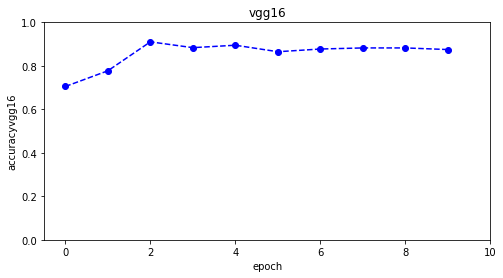

In [ ]:
model = main(PATH="./vgg16.pth", model_in='vgg16')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
<class 'torch.utils.data.dataloader.DataLoader'>
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
device: cuda
model: resnet18
---------------------------------------------------------------

Epoch 0 report: 
Epoch 0 step 39 ave_loss 0.9326
Epoch 0 step 79 ave_loss 0.3448
Epoch 0 step 119 ave_loss 0.1774
Epoch 0 step 159 ave_loss 0.0366
Epoch 0 step 199 ave_loss 0.0144
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.44      0.56       409
          3C       0.81      0.36      0.50       367
          4C       0.68      1.00      0.81       831

    accuracy                           0.71      1607
   macro avg       0.76      0.60      0.62      1607
weighted avg       0.74      0.71      0.68      1607

---------------------------------------------------------------

Epoch 1 report: 
Epoch 1 step 39 ave_loss 0.0102
Epoc

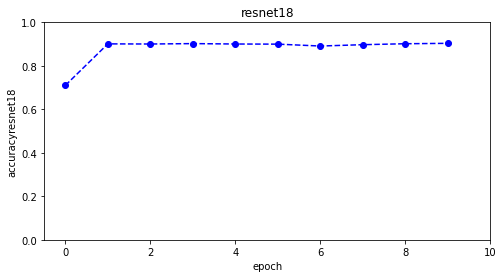

In [ ]:
model = main(PATH="./resnet18.pth", model_in='resnet18')

In [ ]:
model = main(PATH="./resnet50.pth", model_in='resnet50')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Num Images in train set: 6717
Num Images in test set: 1607
Num batch in train set:  210
<class 'torch.utils.data.dataloader.DataLoader'>
class:  {'2C': 0, '3C': 1, '4C': 2}
image size:  torch.Size([3, 224, 224])
device: cuda
model: resnet50
---------------------------------------------------------------

Epoch 0 report: 
Epoch 0 step 39 ave_loss 4.4508
Epoch 0 step 79 ave_loss 1.9542
Epoch 0 step 119 ave_loss 1.2801
Epoch 0 step 159 ave_loss 1.1386
Epoch 0 step 199 ave_loss 1.0470
Test report: 
               precision    recall  f1-score   support

          2C       0.37      0.89      0.52       409
          3C       0.51      0.07      0.12       367
          4C       0.62      0.43      0.51       831

    accuracy                           0.47      1607
   macro avg       0.50      0.46      0.39      1607
weighted avg       0.53      0.47      0.43      1607

---------------------------------------------------------------

Epoch 1 report: 
Epoch 1 step 39 ave_loss 1.0608
Epoc

In [ ]:
# model = main(PATH="./googlenet.pth", model_in='googlenet')